/tmp/ipykernel_419/3747679180.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dt = float(mat['n_Point9']['x_values'][0,0]['increment'][0,0])


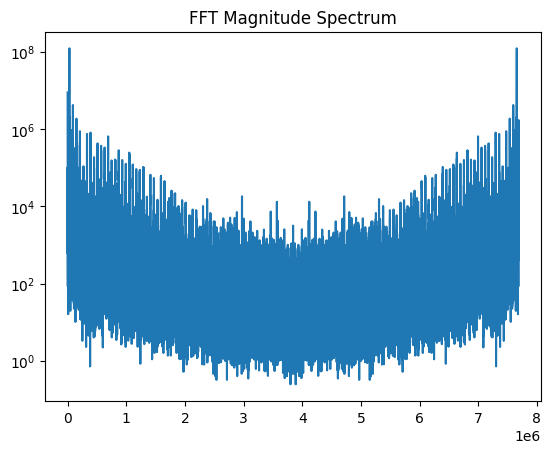

/home/jaszczur/VSCode_Python/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


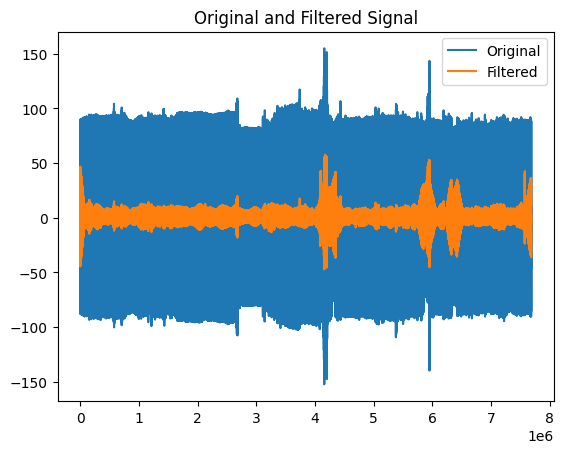

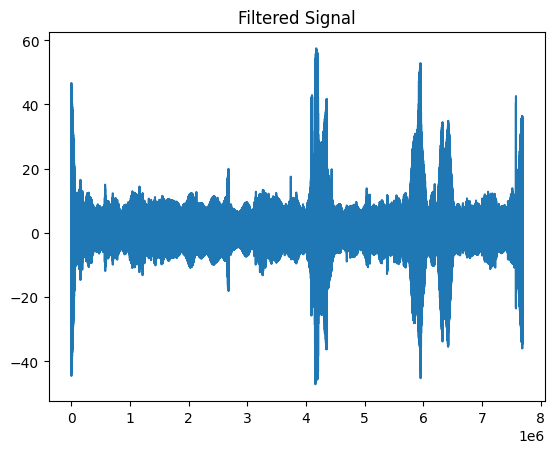

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.fft import fft, ifft

# Load .mat file
mat = loadmat("EMG.mat")
data = mat['n_Point9']['y_values'][0,0]['values'][0,0].squeeze()
dt = float(mat['n_Point9']['x_values'][0,0]['increment'][0,0])

N = len(data)
Fs = 1 / dt
t = np.arange(1, N + 1) * dt
fvec = np.arange(0, N) / N * Fs

data_fft = fft(data)

plt.figure()
plt.semilogy(np.abs(data_fft))
plt.title('FFT Magnitude Spectrum')

# Zero selected frequencies (adjust indices as needed)
data_fft[29997:30049] = 0
data_fft[N//2:] = 0

data_filtered = np.real(ifft(data_fft))

plt.figure()
plt.plot(data, label='Original')
plt.plot(data_filtered, label='Filtered')
plt.legend()
plt.title('Original and Filtered Signal')

plt.figure()
plt.plot(data_filtered)
plt.title('Filtered Signal')
plt.show()

### FFC + CWT

In [2]:
from scipy.signal import butter, filtfilt, iirnotch, hilbert, lfilter
import numpy as np
from numpy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
import pandas as pd
import pywt

In [3]:
signal = data

fs = Fs

/tmp/ipykernel_419/3436543431.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/jaszczur/VSCode_Python/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


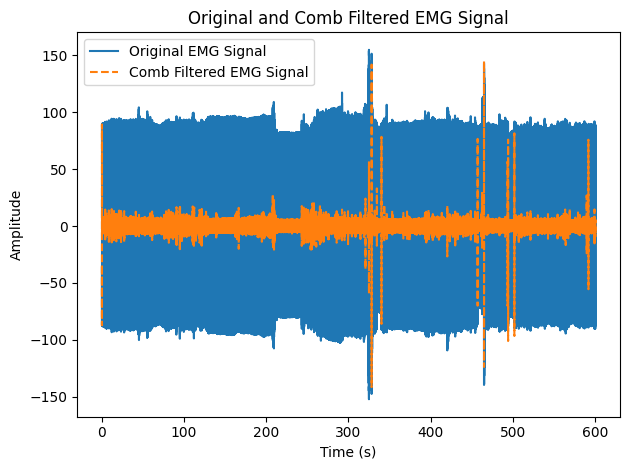

In [4]:
# Define the comb filter
def comb_filter(signal, delay, alpha):
    b = np.zeros(delay + 1)
    b[0] = 1
    b[-1] = -alpha
    a = [1]
    return lfilter(b, a, signal)

# Parameters for the comb filter
delay = int(fs / 50)  # Delay in samples (for 50 Hz)
alpha = 0.95  # Feedback coefficient

# Apply the comb filter to the signal
filtered_signal_FFC = comb_filter(signal, delay, alpha)

# Plot the original and filtered signals
fig, ax = plt.subplots()
ax.plot(t, signal, label='Original EMG Signal')
ax.plot(t, filtered_signal_FFC, label='Comb Filtered EMG Signal', linestyle='--')
ax.set_title("Original and Comb Filtered EMG Signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_419/831182414.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


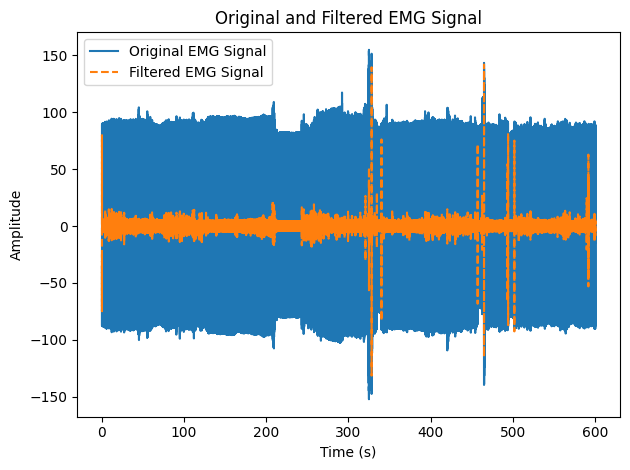

In [5]:
# Design the bandpass filter
lowcut = 20.0
highcut = 500.0
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='band')

# Apply the filter to the signal
filtered_signal = filtfilt(b, a, filtered_signal_FFC)

# Plot the original and filtered signals
fig, ax = plt.subplots()
ax.plot(t, signal, label='Original EMG Signal')
ax.plot(t, filtered_signal, label='Filtered EMG Signal', linestyle='--')
ax.set_title("Original and Filtered EMG Signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.legend()

plt.tight_layout()
plt.show()

signal = filtered_signal

In [6]:
# Wvelet parameters
B = 1.5 # Bandwidth
C = 1.0 # Center frequency
wavelet = 'cmor'+ str(B) + '-' + str(C)
print(f"Wavelet: {wavelet}")

#Scales
wav = pywt.ContinuousWavelet(wavelet) 
width = wav.upper_bound - wav.lower_bound
print("width:",width)

# 2 different cases for scales according to literature
all_frequencies = np.array([6, 500])
# significant_frequencies = np.array([20, 250])

# test = np.array([20, 2000])
# test = test / fs

frequencies = all_frequencies / fs # normalized 

scales = pywt.frequency2scale(wavelet, frequencies)
# scales = pywt.frequency2scale(wavelet, test)
print(scales)

Wavelet: cmor1.5-1.0
width: 16.0
[2133.33333333   25.6       ]


In [ ]:

cwtmatr, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=dt)

print(f"Shape of CWT matrix: {cwtmatr.shape}")
print(f"Shape of frequencies: {freqs.shape}")
print(f"Shape of time: {t.shape}")

'''
cwtmatr:
-real: filtered signal for the given scales.
-abs: envelope of the filtered signal for the given scales.
'''

real_cwt = np.real(cwtmatr[0, :])
abs_cwt= np.abs(cwtmatr[0, :])

# real_cwt = real_cwt[1:-1]

# t = t[1:-1]

# Graph of the cwt real and cwt abs side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot cwt real
axs[0].plot(t, np.real(cwtmatr[0, :]), label='cwt real')
axs[0].set_title("CWT Real")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")
axs[0].legend()

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Original and Filtered Signal')

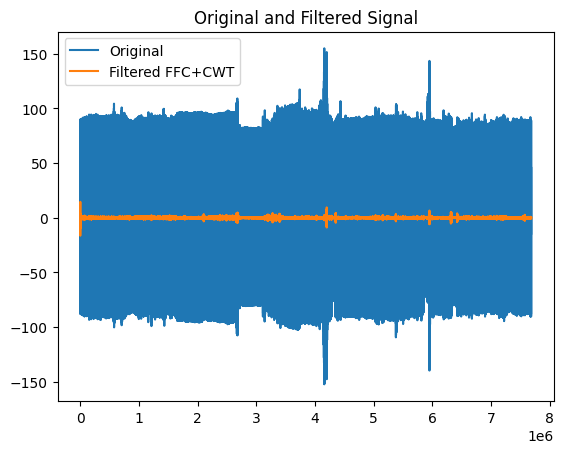

In [ ]:
plt.figure()
plt.plot(data[1 :], label='Original')
plt.plot(real_cwt, label='Filtered FFC+CWT')
plt.legend()
plt.title('Original and Filtered Signal')

In [ ]:
#Scales
wav = pywt.ContinuousWavelet(wavelet) 
width = wav.upper_bound - wav.lower_bound
print("width:",width)

# 2 different cases for scales according to literature
all_frequencies = np.arange(6, 500)

frequencies = all_frequencies / fs # normalized 

scales = pywt.frequency2scale(wavelet, frequencies)
# print(scales)

width: 16.0
[2133.33333333 1828.57142857 1600.         1422.22222222 1280.
 1163.63636364 1066.66666667  984.61538462  914.28571429  853.33333333
  800.          752.94117647  711.11111111  673.68421053  640.
  609.52380952  581.81818182  556.52173913  533.33333333  512.
  492.30769231  474.07407407  457.14285714  441.37931034  426.66666667
  412.90322581  400.          387.87878788  376.47058824  365.71428571
  355.55555556  345.94594595  336.84210526  328.20512821  320.
  312.19512195  304.76190476  297.6744186   290.90909091  284.44444444
  278.26086957  272.34042553  266.66666667  261.2244898   256.
  250.98039216  246.15384615  241.50943396  237.03703704  232.72727273
  228.57142857  224.56140351  220.68965517  216.94915254  213.33333333
  209.83606557  206.4516129   203.17460317  200.          196.92307692
  193.93939394  191.04477612  188.23529412  185.50724638  182.85714286
  180.28169014  177.77777778  175.34246575  172.97297297  170.66666667
  168.42105263  166.23376623  164.

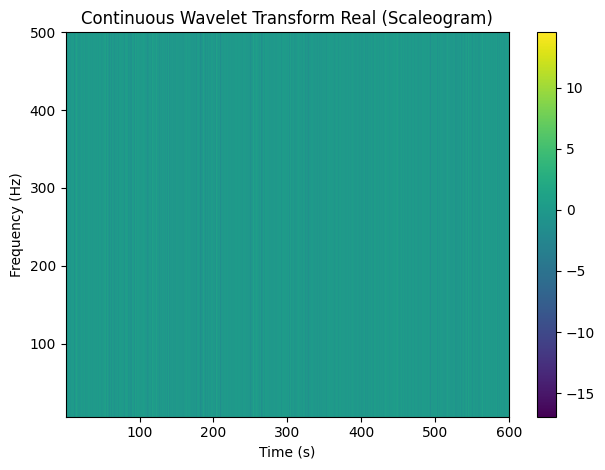

In [ ]:
wtmatr, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=dt)

# Plot result using matplotlib's pcolormesh (image with annotated axes)
fig, ax = plt.subplots()
pcm = ax.pcolormesh(t, freqs, np.real(cwtmatr[:-1,:-1]))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Continuous Wavelet Transform Real (Scaleogram)")
# ax.set_xlim([10, 15])
fig.colorbar(pcm, ax=ax)
plt.tight_layout()
plt.show()